/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Interval 1 — Test RMSE: 0.0651, MAE: 0.0346
Interval 2 — Test RMSE: 0.0810, MAE: 0.0622
Interval 3 — Test RMSE: 0.0602, MAE: 0.0461
Interval 4 — Test RMSE: 0.0824, MAE: 0.0605
Interval 5 — Test RMSE: 0.0627, MAE: 0.0540
Interval 6 — Test RMSE: 0.0524, MAE: 0.0479


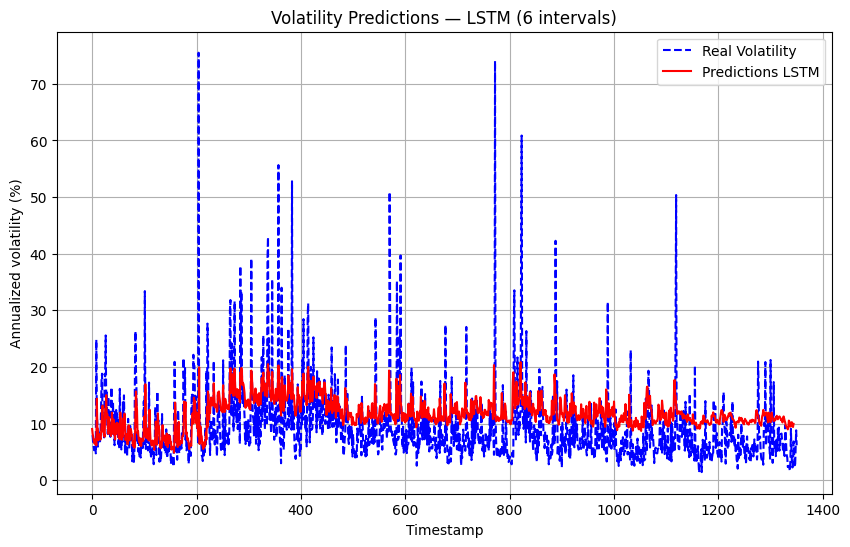

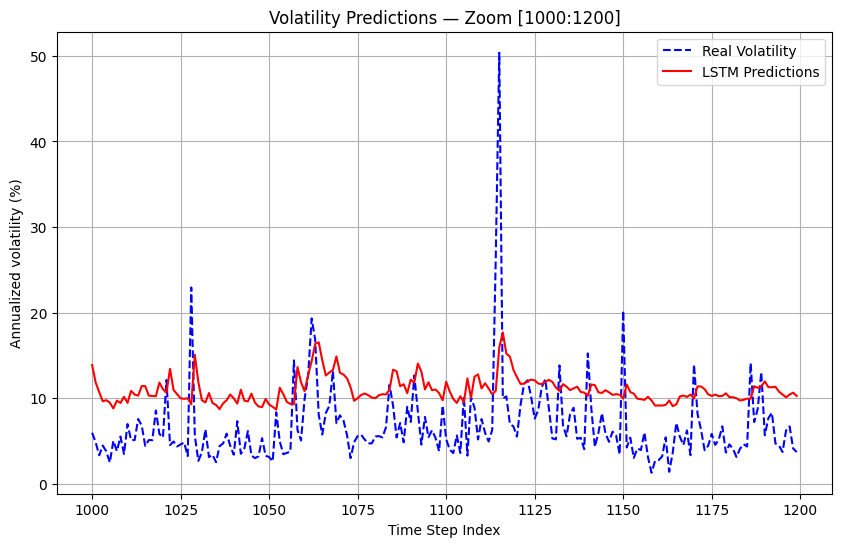

Starting lookback window optimization...
Starting volatility prediction...
Interval 1 — Test RMSE: 0.0693, MAE: 0.0448
Interval 2 — Test RMSE: 0.0835, MAE: 0.0646
Interval 3 — Test RMSE: 0.0642, MAE: 0.0498
Interval 4 — Test RMSE: 0.0830, MAE: 0.0569
Interval 5 — Test RMSE: 0.0565, MAE: 0.0424
Interval 6 — Test RMSE: 0.0454, MAE: 0.0393


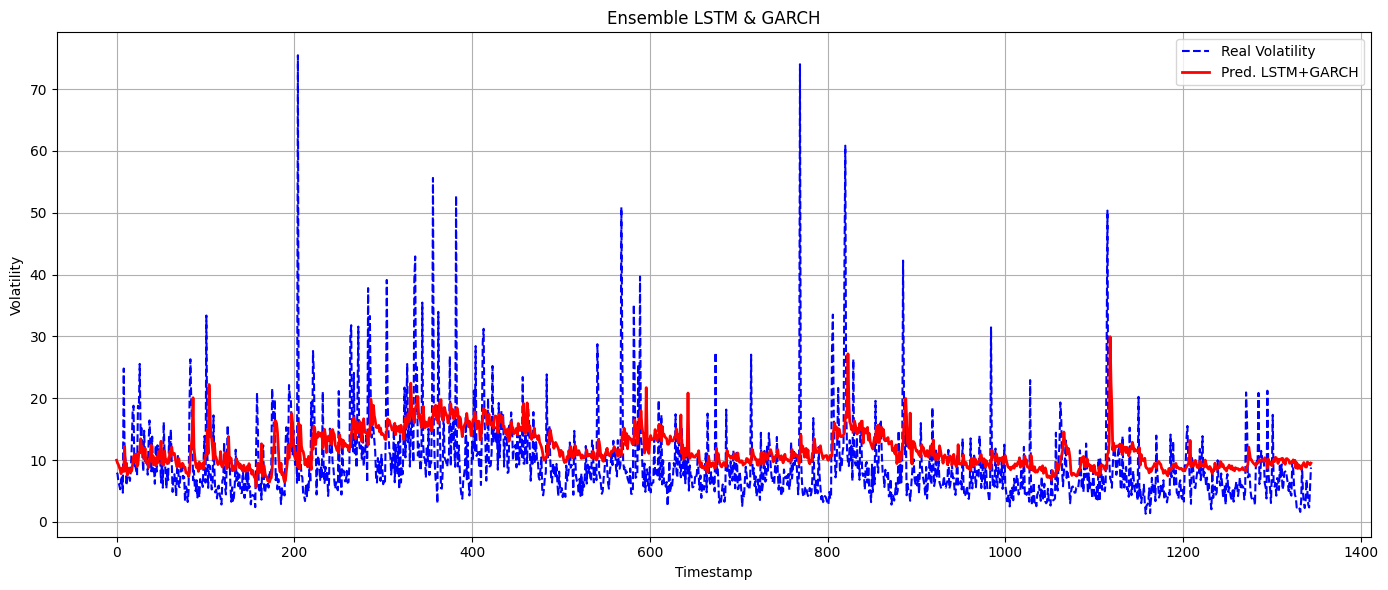

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from Models.LSTM import *
from Models.GARCH import *
from Model_eval import test_lstm


df = pd.read_csv('Data/hourly_data_ff.csv')
df_returns = pd.read_csv('Data/hourly_data_ff_with_returns.csv')
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])




param_grid = {
    'hidden_size_1': [32,64,128,256],
    'hidden_size_2': [32,64,128,256],
    'learning_rate': [0.0005,0.001],
    'weight_decay': [0.0001,0.001],
    'dropout_rate': [0.2,0.4,0.6,0.8]
}


df_lstm, rmse_list, mae_list = test_lstm(
    df,
    param_grid,
    orderbook_timesteps=30,
    future_horizon=1,
    epochs=5,
    batch_size=32
)


df_lstm['timestamp'] = pd.to_datetime(df_lstm['timestamp'])


df_garch, best_lb = test_garch(df_returns, df, plot=False)
df_garch['timestamp'] = pd.to_datetime(df_garch['timestamp'])
df_garch = df_garch.rename(columns={'pred': 'garch_pred'})


df_lstm_renamed = df_lstm.rename(columns={'pred': 'lstm_pred'})
ensemble_df = pd.merge(df_lstm_renamed, df_garch, on='timestamp', how='inner')


ensemble_df['ensemble_pred'] = 0.5 * ensemble_df['lstm_pred'] + 0.5 * ensemble_df['garch_pred']
df_true = df[['timestamp','vol']].drop_duplicates()
ensemble_df = ensemble_df.merge(df_true, on='timestamp', how='inner')

all_trues = ensemble_df['vol'].values
splits_pred  = np.array_split(ensemble_df['ensemble_pred'].values, 6)
splits_truth = np.array_split(all_trues, 6)

for i in range(6):

    rmse = np.sqrt(mean_squared_error(splits_truth[i], splits_pred[i]))
    mae  = mean_absolute_error(splits_truth[i], splits_pred[i])
    print(f"Interval {i+1} — Test RMSE: {rmse/100:.4f}, MAE: {mae/100:.4f}")


plt.figure(figsize=(14, 6))
plt.plot(all_trues, label="Real Volatility", color='blue', linestyle='--')
plt.plot(ensemble_df['ensemble_pred'].values, label="Pred. LSTM+GARCH", color='red', linewidth=2)
plt.title("Ensemble LSTM & GARCH")
plt.xlabel("Timestamp")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()